<center>

# Мэтчинг товаров.

</center>

## Описание проекта.

- __Задача.__
    - разработка алгоритма, который для всех товаров из `validation.csv` найдет 5 похожих из 'base.csv'.
<br><br>
- __Метрика.__ 
    - Необходимо максимизировать метрику `accuracy@5`, которая для каждого объекта вычисляается по формуле:   
$$
accuracy@5 = 100 * \frac{\text{кол-во верно определенных похожих объектов из 5 возможных}} {5}
$$
- __Данные.__
  - `base.csv` : база данных всех товаров.
    - Насчитывает 72 признака и 2918139 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
<br><br>
  - `train.csv` : обучающая выборка, взятая из `base.csv`.
    - Насчитывает 73 признака и 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
    - Признаки включают столбец с размеченными экспертами идентификаторами похожих товаров из `base.csv`
<br><br>
  - `validatation.csv` : база данных товаров, взятых из `base.csv`, для которых необходимо найти похожие.
    - Насчитывает 72 признака и 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
<br><br>
  - `validation_answer.csv` : база данных, с разметкой похожих для товаров из `validatation.csv`.
    - Насчитывает 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.

# Загрузка библиотек 

In [1]:
#!C:\Users\glebs\anaconda3\python.exe -m pip install --upgrade pip

In [2]:
#!pip install scikit-learn --upgrade

In [3]:
#!pip install faiss-cpu 
#!pip install faiss-gpu
#!pip install annoy 

In [4]:
# Для вычислений
import numpy as np
# Для работы с датафреймами
import pandas as pd

from time import perf_counter

# Для сравнения выборок
from scipy.stats import kstest

# Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm.notebook import tqdm
from tqdm.notebook import trange
from tqdm.contrib.itertools import product
# Для подавления FutureWarning от Pandas.
from warnings import simplefilter

from sklearn.preprocessing import (RobustScaler, 
                                   StandardScaler, 
                                   QuantileTransformer)

from sklearn.metrics import (silhouette_score, 
                             davies_bouldin_score)


from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import NearestNeighbors

import faiss
from annoy import AnnoyIndex



In [5]:
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных 

In [6]:
df_base = pd.read_csv(r'C:\Users\glebs\Рабочий стол\base.csv', index_col = 0)
df_train = pd.read_csv(r'C:\Users\glebs\Рабочий стол\train.csv', index_col = 0)
df_val = pd.read_csv(r'C:\Users\glebs\Рабочий стол\validation.csv', index_col = 0)
df_val_ans= pd.read_csv(r'C:\Users\glebs\Рабочий стол\validation_answer.csv', index_col = 0)

# Ознакомление с данными

### Вспомогательные функции.
Введём вспомогательные функции:
- функцию поиска репрезентативного процента выборки;
- фукнцию вычисления процента выбросов;
- фукнцию вывода графиков.

#### Функция поиска репрезентативного процента выборки.
- Принимает датафрейм и список долей для перебора.
- Проводит двусторонние тесты Колмогорова-Смирнова для каждого признака в основной выборке и подвыборке.
- Выводит процент объектов для репрезентативной выборки, если распределения всех признаков идентичны.

In [7]:
def kstest_func(x, y = None, frac = None):
    '''
    Calculates the minimum share of data to be representative by using Kolmogorov-Smirnov 
    test for two dataframes or tests two distributions for equality.
    Args:
    - x: dataframe/series/array
    - y: series/array
    - frac: share of data
    '''
    
    if (isinstance(x, pd.DataFrame) and \
        not y and \
        isinstance(frac, (list, np.ndarray))):
        fracs = frac
        np.random.seed(42)
        
        
        for share in fracs:
            i = 0
            y = x.sample(frac = share, random_state = 12345)
            for col in x.columns:
                if x[col].dtype == 'O':
                    i += 1
                    continue
                _, p_value = kstest(x[col], y[col])
                if p_value < .05:
                    print(f'Выборка из {share:.0%} объектов не репрезентативна')
                    break
                else:
                    i += 1
                #print('i:', i, 'share:', share)
                if i == len(x.columns):
                    print('Распределения признаков в выборках одинаковы при' +
                            f' выборке {share:.0%} объектов.')
                    return
        print('Найти репрезентативный процент выборки не удалось')
        
    else:
        _, p_value = kstest(x, y)
        if p_value < .05:
            print(f'Распределение признаков различны.')
        else:
            print(f'Распределение признаков одинаковы.')

#### Функция вычисления процента выбросов.

- Фукнция принимает датафрейм и коэф. для расчета пограничных значений (по умолчанию равный 1.5, что соответствует ящику с усами с размахов 2.7$\sigma$
- Функция вычислит и выведет процент значений вне границ, и при необходимсоти, пограничные значения.

In [8]:
def get_outliers_ratio(df, iqr_coeff = 1.5):
    '''
    ///
    '''
    
    
    for col in range(0, len(df.columns)):
        if df.iloc[:, col].dtype == 'O':
            continue
        iqr = df.iloc[:, col].quantile(.75) - df.iloc[:, col].quantile(.25) 
        upper = df.iloc[:, col].quantile(.75) + iqr * iqr_coeff
        lower = df.iloc[:, col].quantile(.25) - iqr * iqr_coeff
        
        if upper >= df.iloc[:, col].max():
            upper = df.iloc[:, col].max()
        if lower <= df.iloc[:, col].min():
            lower = df.iloc[:, col].min()
        else:
            pass

        outliers_ratio = (
            (df.iloc[:, col][df.iloc[:, col] > upper].count() + 
             df.iloc[:, col][df.iloc[:, col] < lower].count()) / 
            len(df.iloc[:, col])
            ) 
        
        yield outliers_ratio

In [9]:
def plot_graphs(df : pd.DataFrame, name = None, sample_frac = None,
               outliers = True, iqr_coeff = 1.5):
    '''
    ...
    '''
    
    # Проверка на необходимость сэмплирования.
    if sample_frac:
        df_plot = df.sample(frac = sample_frac, random_state = 12345)
        sample_share = f' {sample_frac:.0%} выборки'
    else:
        df_plot = df.copy()
        sample_share = f'100% выборки'
        
    name = f' датафрейма "{name}"' if name else ''
    
    axs = df_plot.hist(figsize = [20, 20], bins = 50)
    outliers_ratio = np.array(list(get_outliers_ratio(df)))
    if outliers:
        ind = 0 
        for ax, col in zip(axs.flatten(), df_plot.columns):      
            #if df.iloc[:, df.columns.get_loc(col)].dtype == 'O':
            #    continue
            ax.set_title(f'Признак "{col}". \nВыборосв: ' +
                        f'{outliers_ratio[ind]:.1%}')
            ind += 1
    plt.suptitle('Гистограммы' + sample_share + name + '.', y=.99, fontsize=16)
    plt.tight_layout()
    plt.show();

    # Выведем диаграммы размаха.
    df_plot.plot(kind='box', grid=True, figsize=[20, 8])
    plt.title('Диаграммы размаха'  + sample_share + name + '.', fontsize=16)
    plt.tight_layout()
    plt.show();

### Вывод информации и графиков.

#### Вывод общей информации о данных.

In [10]:
for df, name in zip(
    [df_base, df_train, df_val, df_val_ans],
    ['Общая выборка "df_base".' ,'Обучающая выборка "df_train".', 
     'Валидационная выборка "df_val".', 'Ответы вал. выборки "df_val_ans".']
    ):
    display(df.head().style.set_caption(name))
    print('\n')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.880890,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.061510,-32.458237,-57.420560,36.207405,182.716770,-28.071688,-5.209374,-1.732182,-91.091860,-79.466670,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.765030,-10.069234,-143.005040,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.340580,-123.626080,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.067540,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.513610,-44.659496,-80.442210,5.149714,-64.518950,-138.777630,-42.808693,38.800827,-151.762180,-74.389090,63.666340,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.533480,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.304350,-126.768900,-68.853530,8.314717,143.081740,8.778257,15.157185,48.246360,-244.954860,-80.279420,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.155880,-7.579590,-174.369950,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.552630,-110.340170,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.010420,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.777050,58.887608,-71.595340,-251.952358,11.392853,-148.571660,-117.767525,41.100000,-157.829400,-94.446806,68.202110,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.413830,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.822450,-22.486748,-51.666990,2.521726,140.585450,-22.039230,-7.128634,-5.184787,-111.712120,-79.029270,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.387710,-21.483440,-144.845370,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.061660,-118.758550,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.321370,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.733890,65.320880,-114.037180,-529.396956,-101.581375,-134.658220,-76.397800,46.011803,-207.144420,127.325570,65.566180,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.067630,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.470440,-104.537780,-82.388490,-79.986740,113.596310,-38.995880,-4.787360,8.327808,-124.855760,-79.109020,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.201980,10.613454,-134.934340,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.045300,-124.295770,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.769270,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.314320,7.912551,-62.188920,-540.321044,-89.588715,-149.326690,-70.647940,-6.358921,-147.201050,-37.692750,66.202890,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.608030,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.342450,-38.982060,-50.228867,-26.690920,135.272900,-7.510103,8.924209,111.576950,-130.833190,-79.315850,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.385530,-44.059470,-148.131850,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.372440,-123.708980,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.540370,57.695343,-67.822630,-29.38913

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936680,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.082690,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.841370,-78.512180,-94.428940,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.715840,-27.042316,-133.212170,106.420746,-303.939233,48.730790,58.185707,24.250950,-151.224100,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.991640,-31.948470,82.314430,-115.830470,-243.309390,6.622036,-132.197660,68.712560,-38.806824,62.937435,-132.654450,89.189026,87.039780,-121.279880,-6.986934,-206.513820,29.485587,-77.029590,-132.386170,-105.427820,70.107360,-155.802570,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.260390,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.605800,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267030,-78.659430,-92.761490,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.357910,48.810093,-115.922150,87.464220,-222.286354,25.124150,91.887140,-30.636870,-136.593140,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.150900,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061080,-7.139753,75.862400,-112.045110,82.857730,54.067215,-134.005390,-26.142574,-214.632110,-457.848461,21.459618,-137.411360,-40.812233,4.669178,-151.697710,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.401980,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.346560,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.505680,-78.372925,-69.324480,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.760620,0.178065,-183.069670,99.053570,-1018.469545,-51.801120,97.766770,-10.865850,-144.423160,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.639530,-30.211614,48.527400,-122.406640,-112.713620,53.461838,-31.117260,107.841510,16.482935,77.934480,-95.618730,91.460075,63.119510,-126.939250,8.066627,-195.677670,-163.120000,-72.830000,-139.223070,-52.031662,78.039764,-169.146200,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.517070,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.906830,-78.789320,-78.737090,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.281800,-54.959310,-136.988540,63.880493,-1018.469545,89.228930,65.919960,-24.078644,-152.334100,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.958370,-30.800995,123.623400,-37.540867,-72.139800,71.240990,-168.115590,118.236450,-18.065195,37.255720,-137.691040,87.500770,62.437290,-131.260640,35.692660,-86.038830,-379.339090,-153.465770,-131.198290,-61.567047,44.515266,-145.416750,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052540,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.153020,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.554630,-79.066610,-77.926460,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.693920,-20.604088,-146.591280,78.849570,-780.449185,87.560770,73.036660,16.891030,-144.657900,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.184970,-53.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926790,110.745940,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.892800,-140.968570,-57.987164,-22.868887,150.895520,7.965574,17.622066,-34.868217,-216.138550,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.307080,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.162770,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.261570,-143.656480,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.486870,-39.484753,-124.384575,-307.949760,45.506813,-144.190950,-75.513020,52.830902,-143.439450,59.051935,69.282240,61.927513,111.592530,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.417620,114.449910,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.717250,-63.951330,-52.369495,-33.390945,148.619500,-22.483830,15.164185,-56.202000,-153.614380,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.383910,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.538380,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.531000,-259.636050,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.075260,-25.169033,-176.176880,-655.836897,-99.238370,-141.535220,-79.441830,29.185436,-168.605900,-82.872443,70.765600,-65.975950,97.077160,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.160930,96.446160,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.309540,-31.378445,-8.788761,2.285323,133.266110,-41.309080,14.305538,-18.231812,-205.533700,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.368500,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.934620,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.656990,-162.615700,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.566180,-12.822194,-154.197650,-407.199067,5.522629,-126.812970,-134.795410,37.368730,-159.662310,-119.232725,67.710440,86.002060,137.636410,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.060440,83.697080,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.271960,-71.406456,-65.349320,24.377070,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.309140,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.906520,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.692410,-141.523180,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.048870,-57.156870,-56.335075,-318.680065,-15.984783,-128.101330,-77.236110,44.100494,-132.530120,-106.318982,70.883960,23.577892,133.183960,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.884950,165.453920,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.214170,-26.393860,34.423640,50.938890,157.683180,-23.786497,-33.175415,-0.592607,-193.318540,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.268950,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.168150,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.257370,-175.656780,

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [11]:
for df, name in zip(
    [df_base, df_train, df_val, df_val_ans],
    ['Общая выборка "df_base".' ,'Обучающая выборка "df_train".', 
     'Валидационная выборка "df_val".', 'Ответы вал. выборки "df_val_ans".']
    ):
    print(name + '\n' + '-' * 30)
    print('Рамзер датафрейма:')
    display(df.shape)
    print('Тип данных:')
    display(df.info())
    print('Общее кол-во пропусков в датафрейме:')
    display(df.isna().sum().sum())
    print('Общее кол-во дупликатов в датафрейме:')
    display(df.duplicated().sum().sum())
    print('$' * 70, '\n\n')

Общая выборка "df_base".
------------------------------
Рамзер датафрейма:


(2918139, 72)

Тип данных:
<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39  

None

Общее кол-во пропусков в датафрейме:


0

Общее кол-во дупликатов в датафрейме:


0

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ 


Обучающая выборка "df_train".
------------------------------
Рамзер датафрейма:


(100000, 73)

Тип данных:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float

None

Общее кол-во пропусков в датафрейме:


0

Общее кол-во дупликатов в датафрейме:


0

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ 


Валидационная выборка "df_val".
------------------------------
Рамзер датафрейма:


(100000, 72)

Тип данных:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null 

None

Общее кол-во пропусков в датафрейме:


0

Общее кол-во дупликатов в датафрейме:


0

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ 


Ответы вал. выборки "df_val_ans".
------------------------------
Рамзер датафрейма:


(100000, 1)

Тип данных:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


None

Общее кол-во пропусков в датафрейме:


0

Общее кол-во дупликатов в датафрейме:


8498

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ 




#### Вывод графиков ИАД.

- Выводим графики только для `df_base` т.к. остальные датафреймы являются выборками из него.
- Т.к. `df_base` достаточно большой датасет, то для экономии времени вызовим к нему функцию поиска  репрезентативной выборки

In [12]:
%%time
kstest_func(x = df_base, frac = np.linspace(.12, .2, 8))

Выборка из 12% объектов не репрезентативна
Выборка из 13% объектов не репрезентативна
Распределения признаков в выборках одинаковы при выборке 14% объектов.
CPU times: total: 1min 13s
Wall time: 1min 13s


- Вызовем функцию и выведем графики для репрезентативной подвыборки. 

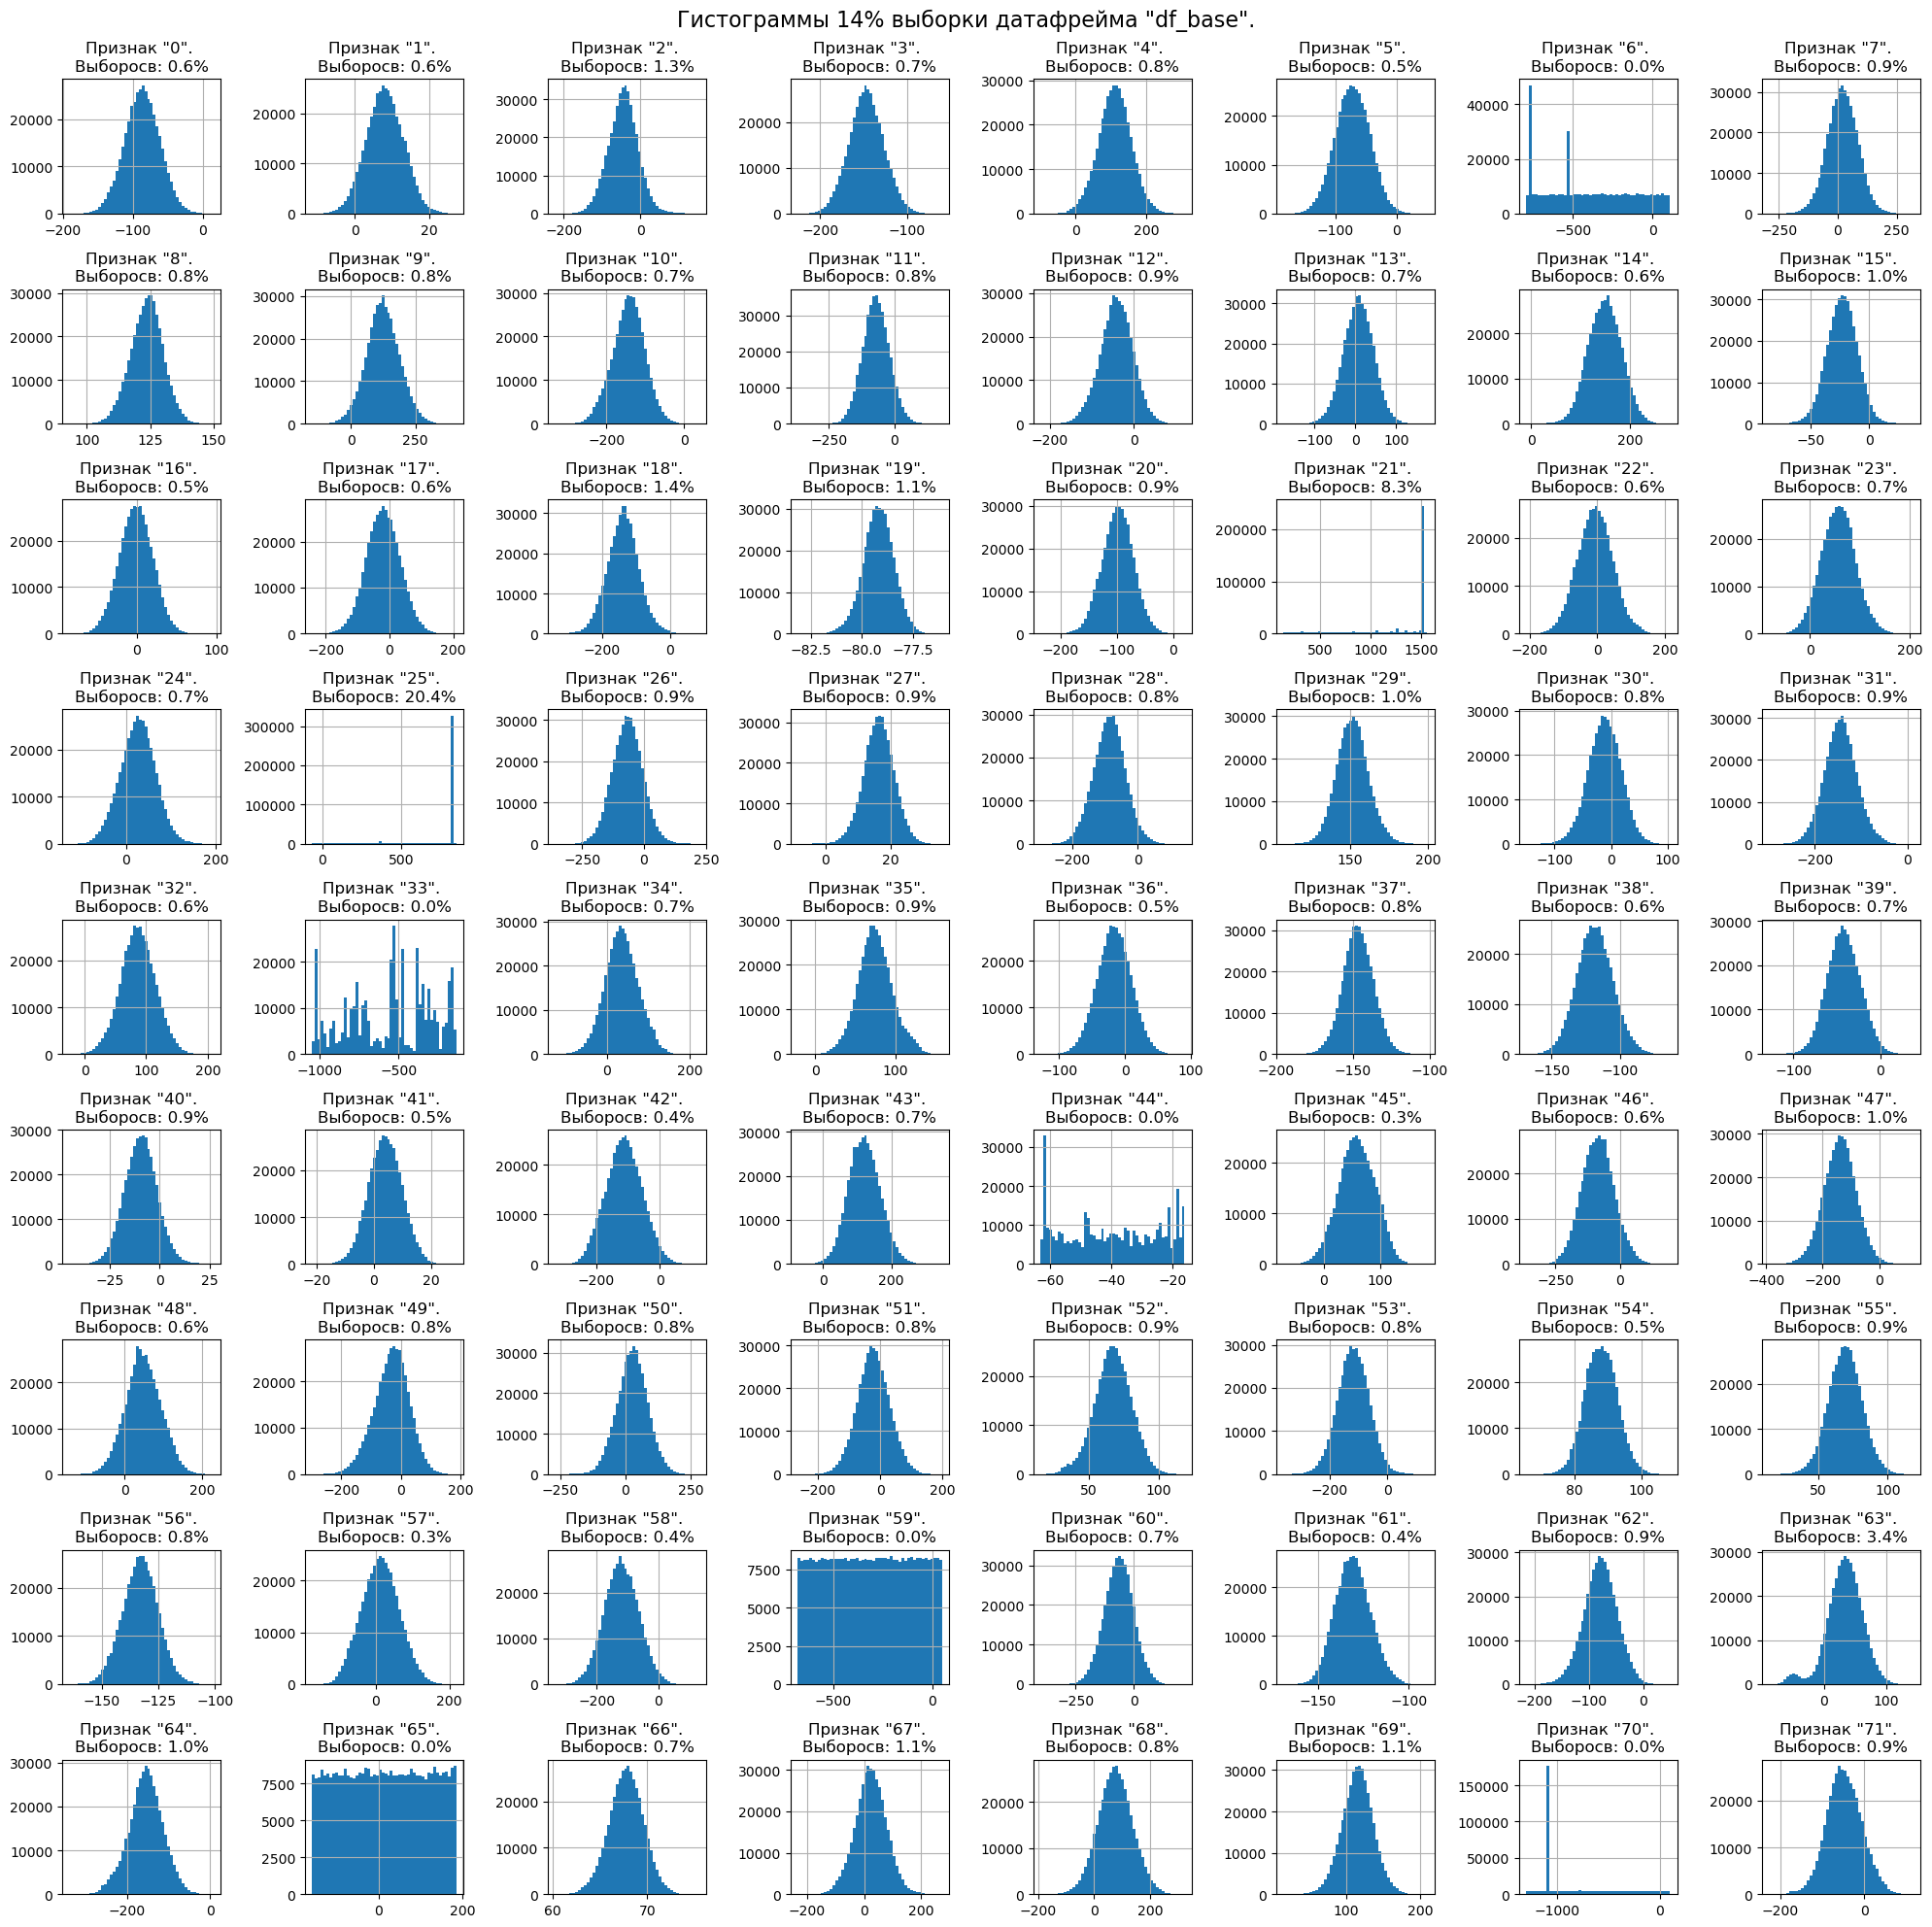

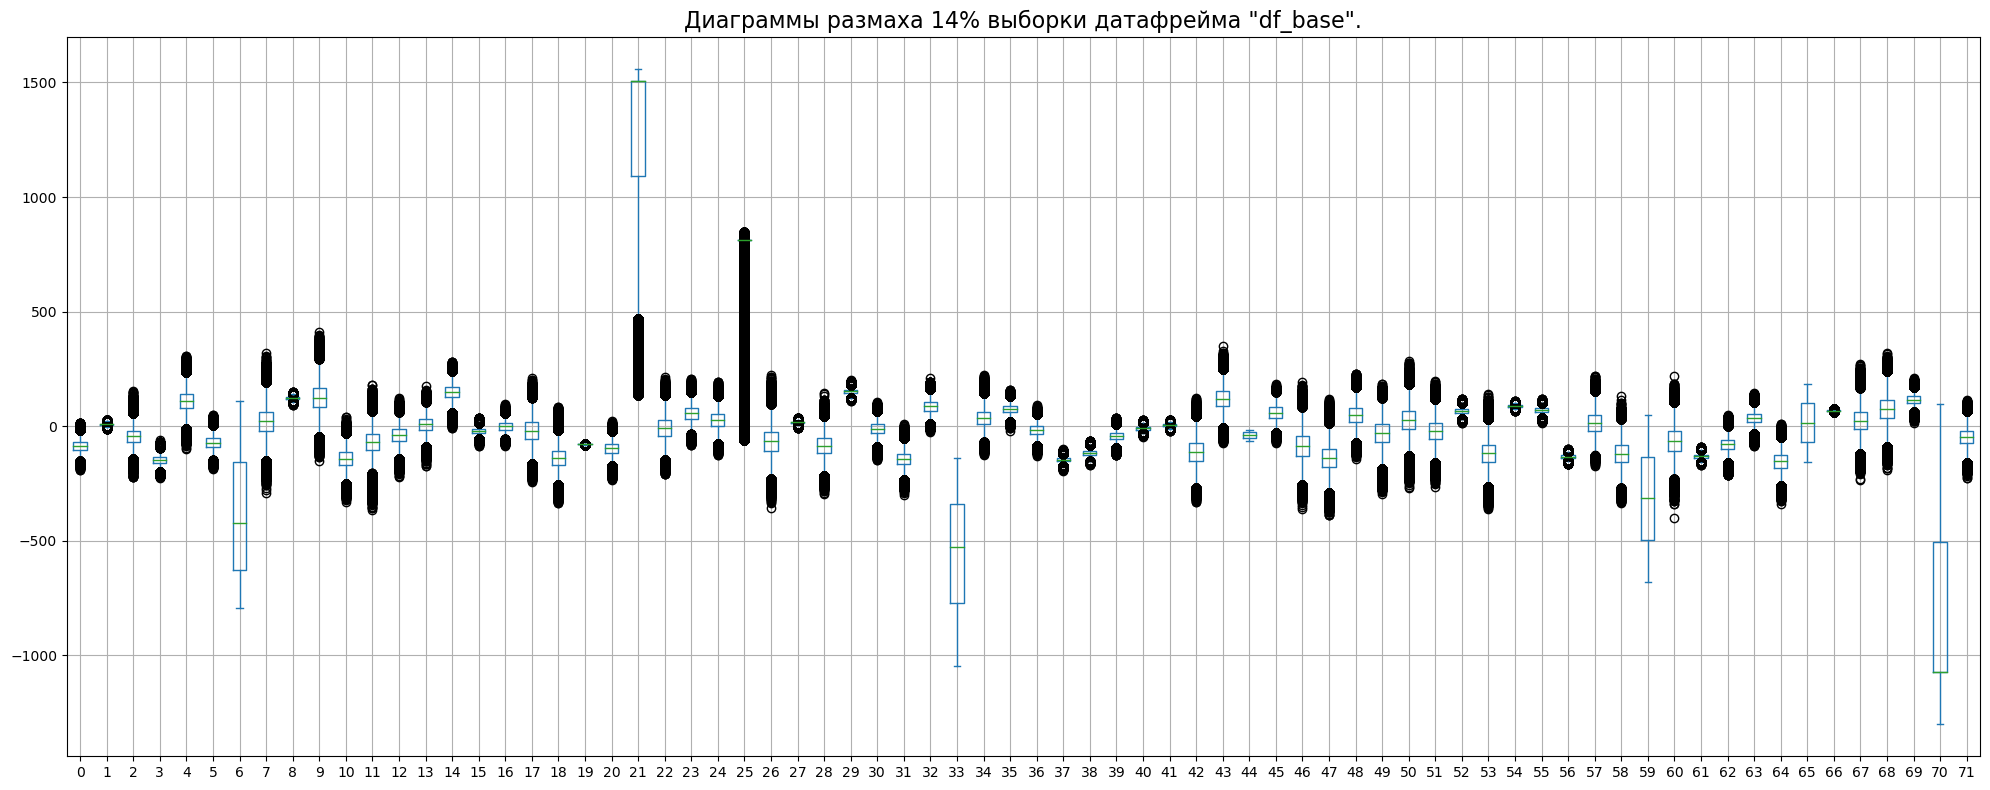

CPU times: total: 24.6 s
Wall time: 23.6 s


In [13]:
%%time
plot_graphs(df=df_base, name='df_base', sample_frac=.14)

#### Вывод доп. информации.

In [14]:
df_base.sample(frac = .14, random_state = 12345).describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,408539.000000,408539.000000,408539.000000,408539.000000,408539.000000,408539.000000,408539.000000,408539.000000,408539.000000,408539.000000,...,408539.000000,408539.000000,408539.000000,408539.000000,408539.000000,408539.000000,408539.000000,408539.000000,408539.000000,408539.000000
mean,-86.195723,8.085257,-44.590504,-146.638252,111.304085,-71.974657,-392.174102,20.293114,123.692538,124.454323,...,-79.009461,33.339571,-154.851058,14.425449,67.793048,23.535739,74.963828,115.613917,-798.414542,-47.733089
std,24.885303,4.954461,38.658868,19.860292,46.345128,28.170825,271.190287,64.230631,6.360540,64.430539,...,30.505447,28.862089,41.284880,98.982740,1.825015,55.345435,61.470918,21.169498,385.972958,41.790265
min,-190.338640,-11.525267,-222.096950,-225.590360,-98.057220,-184.963710,-791.466981,-291.179400,93.183750,-151.582860,...,-214.970730,-88.110750,-338.454280,-157.593866,60.247500,-232.945660,-190.483150,15.724480,-1297.931468,-226.714780
25%,-102.980890,4.709517,-69.630160,-159.962510,80.582357,-91.338135,-627.960206,-22.224394,119.481310,81.821545,...,-98.786915,17.055091,-180.792685,-71.275938,66.583305,-12.426853,33.708275,101.732653,-1074.464888,-75.598290
50%,-86.200460,8.046451,-43.798298,-146.759200,111.839554,-71.936460,-421.669745,20.778706,123.895420,123.451370,...,-78.463860,34.778500,-153.992510,14.316246,67.814660,23.430828,75.007180,116.067024,-1074.464888,-48.550095
75%,-69.223980,11.473961,-19.569629,-133.290120,142.320395,-52.424471,-157.459771,63.804378,127.978287,167.062615,...,-58.494576,52.227890,-127.347500,99.983928,69.031080,59.879417,115.980670,129.609295,-504.045830,-19.681050
max,15.310280,27.324516,152.656560,-60.048027,308.063320,50.373047,109.631203,318.193300,149.902530,409.489720,...,48.822197,142.830350,7.965790,185.096896,75.474625,272.494170,321.289430,209.411740,98.748188,115.436250


#### Вывод матрици корреляции.

- Выведем матрицу линейной корреляции только для основного датафрейма, т.к. остальные являются подмножествами

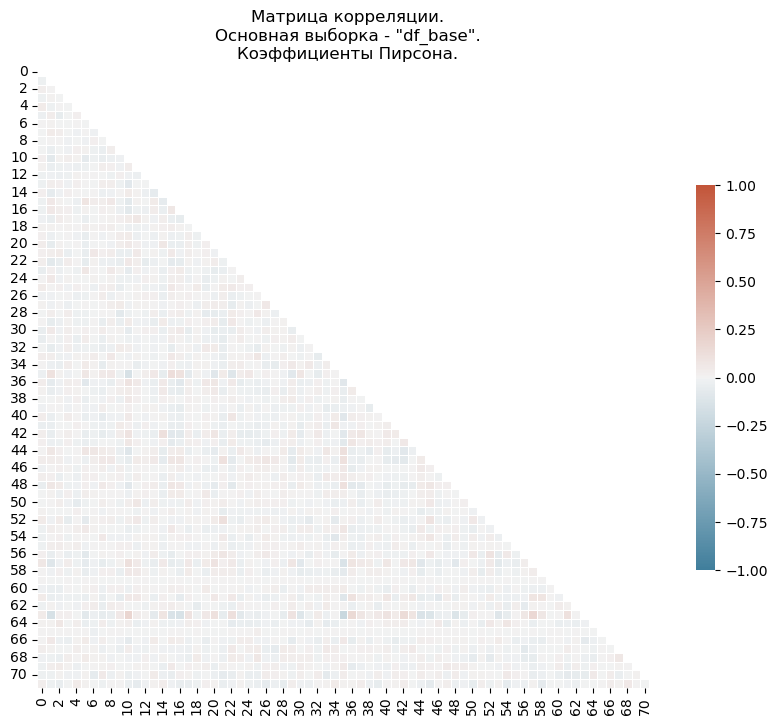

In [15]:
# Определим треугольную маску выводимых значений и цветовую схему.
mask_corr = np.triu(np.ones_like(df_train.corr(numeric_only=True), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Выведем матрицы корреляции с коэфф. Пирсона.
plt.figure(figsize=(10, 10))
sns.heatmap(df_base.corr(numeric_only=True), mask=mask_corr, cmap=cmap,
            vmax=1, vmin=-1, square=True, linewidths=.7, cbar_kws={"shrink": .5})
plt.title(f'Матрица корреляции.\nОсновная выборка - "df_base".\nКоэффициенты Пирсона.')
plt.show();

### Вывод ИАД.

- Размер датасетов:
    - `df_base`: 2918139 X 72 с идентификаторами объектов в индексе;
    - `df_train`: 100000 X 73, в т.ч. признак ответов, и с идентификаторами объектов в индексе;
    - `df_val`: 100000 X 72 с идентификаторами объектов в индексе;
    - `df_val_ans`: 100000 X 1 - признак ответов с идентификаторами объектов в индексе.
- __Пропуски и дубликаты.__
  - Данные не имеют пропусков и дубликатов за исключением дубликатов списка ответов валидационной выборки `df_val_answer`, которые означают, что одному товару могут соответствовать несколько.
<br><br>
- __Распределение признаков.__
  - Признаки имеют различный масштаб.
  - Признаки 6, 21, 25, 33, 44, 59, 65, 70 имеют ненормальное распределение. Остальные признаки имеют распределения приближенные к нормальному.
<br><br> 
- __Корреляция признаков / мультиколлинеарность.__
  - Корреляция признаков отсутствует.

# Предобработка данных.

#### Разделение `df_train`.

In [16]:
target_train = df_train['Target']
df_train.drop('Target', axis = 1, inplace = True)

print('Выделенный столбец с ответами для "df_train". Первые' + 
      ' 5 строк.')
display(target_train.head())
print('-' * 70, '\n')
print('Признаки датафрейма "df_train"')
display(df_train.columns)

Выделенный столбец с ответами для "df_train". Первые 5 строк.


Id
0-query     675816-base
1-query     366656-base
2-query    1447819-base
3-query    1472602-base
4-query     717819-base
Name: Target, dtype: object

---------------------------------------------------------------------- 

Признаки датафрейма "df_train"


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

## Базовые модели.

Для проведения тестов используем базовые модели `FAISS` и `ANNOY`, т.к. они значительно превосходят связку `KMeans` + `NearestNeighbors` в скорости. 

- Принцип работы `FAISS`
    - Создание инвертированного индекса.
    - Поиск похожих сначала по центроидам, затем по выбранным кластерам.
- Принцип работы `ANNOY`
    - Создание индекса из леса бинарных деревьев, состоящих из итеративно разделенных равноудаленными гиперплоскостями пространтв.
    - Поиск похожих спуском по деревьям со сравнением узлов и искомым вектором.

### Функция вычисления accuracy@5 для `FAISS`, `ANNOY`.

Введем ф-ию, которая

- Принимает на вход: датафрейм со всеми о

$$
accuracy@5 = 100 * \frac{\text{кол-во верно определенных похожих объектов из 5 возможных}} {5}
$$

In [17]:
# Реализовать FAISS не получилось. Умирало ядро, а потом стало бесконечно работать с 100% нагрузкой на ЦП. 
# Даже с кодом, который был представлен в бейзлайне.

In [18]:
def get_accuracy(df, df_eval, target, 
                 model_type = None, 
                 faiss_n_clust = None,
                 faiss_index = 'ivf_flat',
                 faiss_metric = 'euclidian',
                 faiss_train_sample_size = None, 
                 faiss_pca_dims = None,
                 annoy_distance_type = 'euclidean',
                 annoy_n_trees = 10,
                 annoy_search_n_nodes = -1,
                 k_similar = 5,
                 SEED = 12345):
    
    model_type = [model_type] if isinstance(model_type, str) else model_type
    dims = df.shape[1]
    base_index = {k: v for k, v in enumerate(df.index.to_list())}
    
    # ANNOY
    if 'annoy' in model_type:

            # Определим индекс ANNOY.
            annoy_index = AnnoyIndex(dims, annoy_distance_type)
            annoy_index.set_seed(SEED)
            # Добавим векторы и их индексы.
            for i, v in zip(range(df.shape[0]), df.values):
                annoy_index.add_item(i, v)

            # Построим индекс.
            annoy_index.build(annoy_n_trees, n_jobs=-1)

            start_annoy = perf_counter()

            # Получим K похожих элементов для каждого запроса и собрём в список.
            idx = []
            for v in df_eval.values:
                idx.append(annoy_index.get_nns_by_vector(
                    v,
                    k_similar,
                    search_k=annoy_search_n_nodes)
                )

            # Вычислим целевую метрику accuracy@k для ANNOY.
            acc_annoy = 0
            for t, el in zip(target.values.tolist(), idx):
                acc_annoy += int(t in [base_index[r] for r in el])

            # Вычислим время выполнения.
            time_annoy = perf_counter() - start_annoy

        # Выведем метрику и время исполнения для каждого/всех алгоритмов.
    if model_type == ['annoy']:
        return (round((100 * acc_annoy / len(idx)), 3), round(time_annoy, 2))
    elif all(model in model_type for model in ['faiss', 'annoy']):
        return (round((100 * acc_faiss / len(idx)), 3), round(time_faiss, 2),
                round((100 * acc_annoy / len(idx)), 3), round(time_annoy, 2))

In [19]:
%%time
(acc_annoy, time_annoy) = get_accuracy(df = df_base, 
                                       df_eval = df_train, 
                                       target = target_train,
                                       model_type = 'annoy',
                                       annoy_n_trees = 50
                                      )


columns = pd.MultiIndex.from_tuples((('Модель FAISS', 'accuracy@5:'),
                                    ('Модель FAISS', 'Время поиска (сек.):')))


base_results = pd.DataFrame([[acc_annoy, time_annoy]],
                           columns=columns)


CPU times: total: 8min 52s
Wall time: 1min 43s


### Базовые модели. Первичные оценки.
- Получим первыичные значения целевой метрики accuracy@5 на базовых моделях с произвольно выбранными кол-ми кластеров и деревьев для сравнения со значениями при проведении тестов. 

In [20]:
display(base_results
        .style
        .format(precision=3)
        .set_caption('Первичные оценки базовых моделей.'))

#### Первичные оценки. Выводы.
- Значения целевой метрики для двух базовых алгоритмов оставляют желать лучшего. 

### Базовые модели. Удаление признаков.
- Заменим одномерные выбросы средним
- Проверим метрику на базовых моделях при поочередном удалении признаков с ненормалаьным распределением распределением.

In [23]:
def outliers_to_means(df, n_sigma=2.7):
    df.mask(~zscore(df).abs().lt(n_sigma), inplace=True)
    df = df.apply(lambda x: x.fillna(x.mean()))
    return df

In [24]:
%%time
# Запишем датафреймы с удаляемыми признаками в переменные.
cols = ['6', '21', '25', '33', '44', '59', '65', '70']
df_base_t = df_base.drop(cols, axis=1)
df_train_t = df_train.drop(cols, axis=1)

# Зададим экземпляр класса алгоритма мастабирования.
rs = RobustScaler()

# Смасштабируем признаки и запишем их в датафреймы.
df_base_t = pd.DataFrame(rs.fit_transform(df_base_t),
                         columns=df_base_t.columns,
                         index=df_base_t.index)
df_train_t = pd.DataFrame(rs.transform(df_train_t),
                          columns=df_train_t.columns,
                          index=df_train_t.index)

# Получим значения целевой метрики acuracy@5.
(acc_annoy, time_annoy)  = get_accuracy(
     df=df_base_t, df_eval=df_train_t, 
     target=target_train,
     model_type=['annoy'],
     annoy_n_trees = 50
 )

# Создадим и выведем таблицу с результатами.
columns = pd.MultiIndex.from_tuples(
    (('Модель ANNOY', 'accuracy@5:'),
     ('Модель ANNOY', 'Время поиска (сек.):'))
)

scale_results_1 = pd.DataFrame(
    [[acc_annoy, time_annoy]],
    columns=columns
)
display(scale_results_1
        .style
        .format(precision=3)
        .set_caption('Оценки базовых моделей с удалением признаков. Вариант 1.'))

CPU times: total: 8min 46s
Wall time: 1min 57s


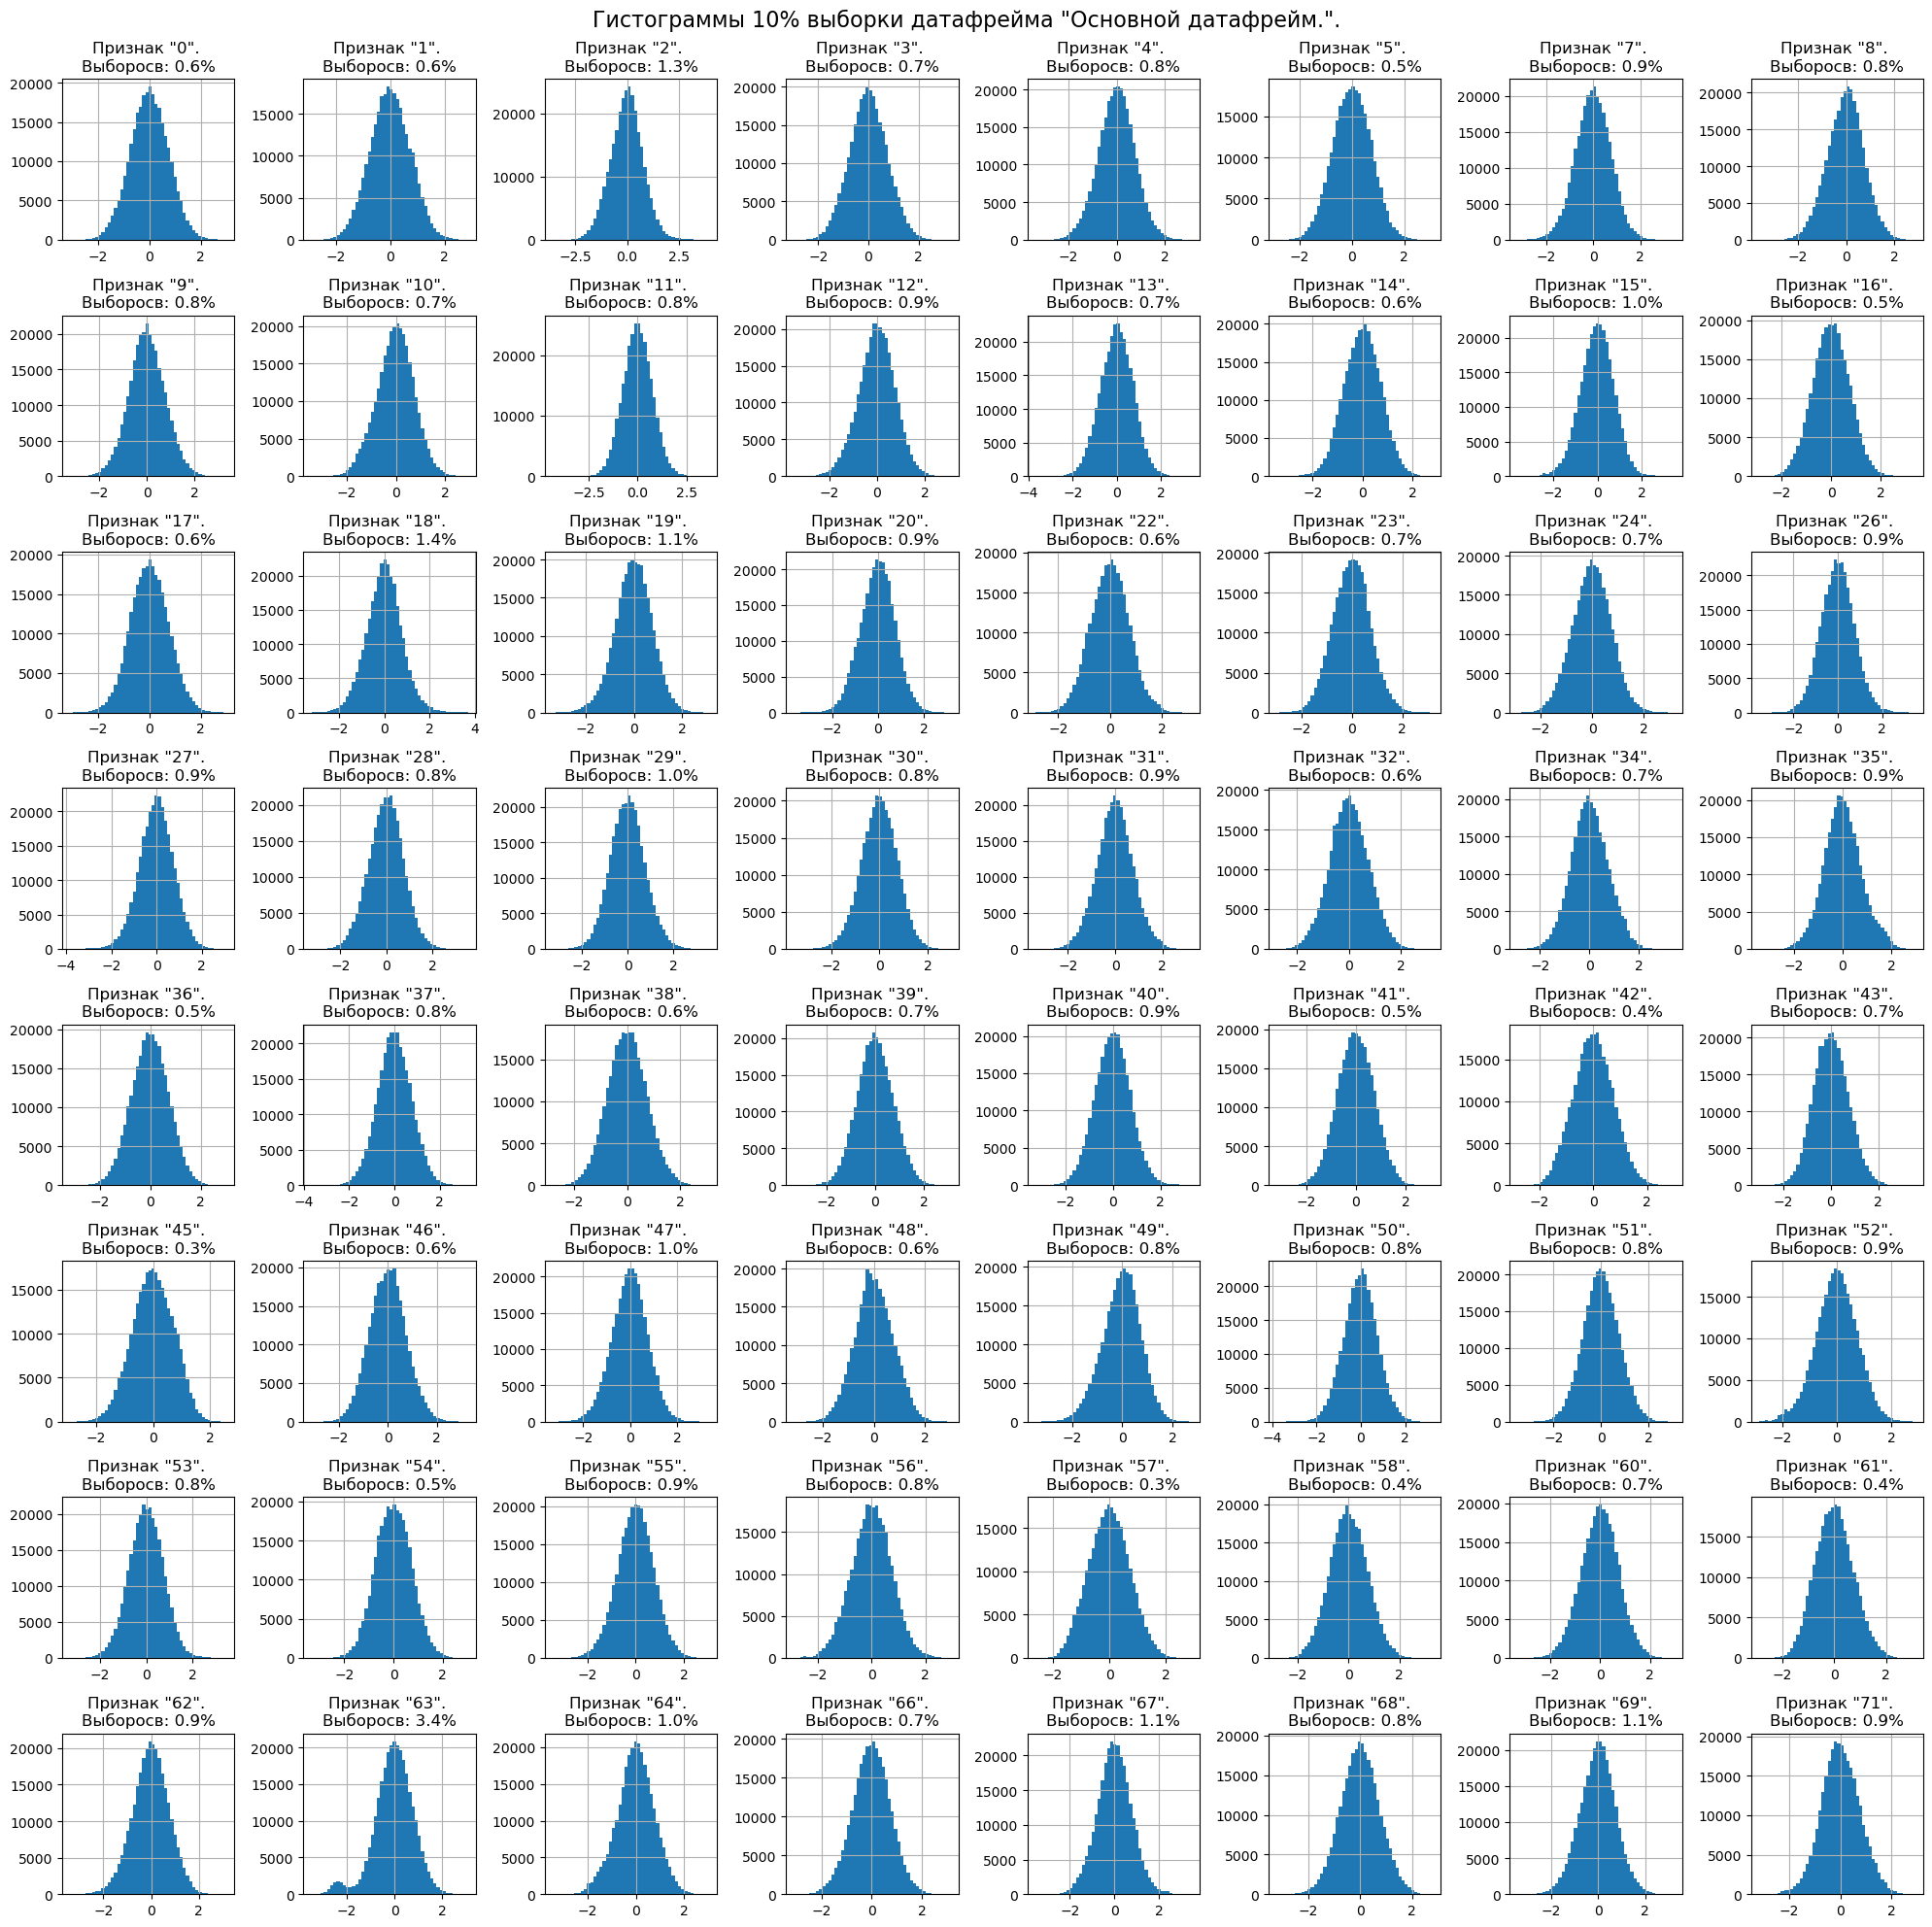

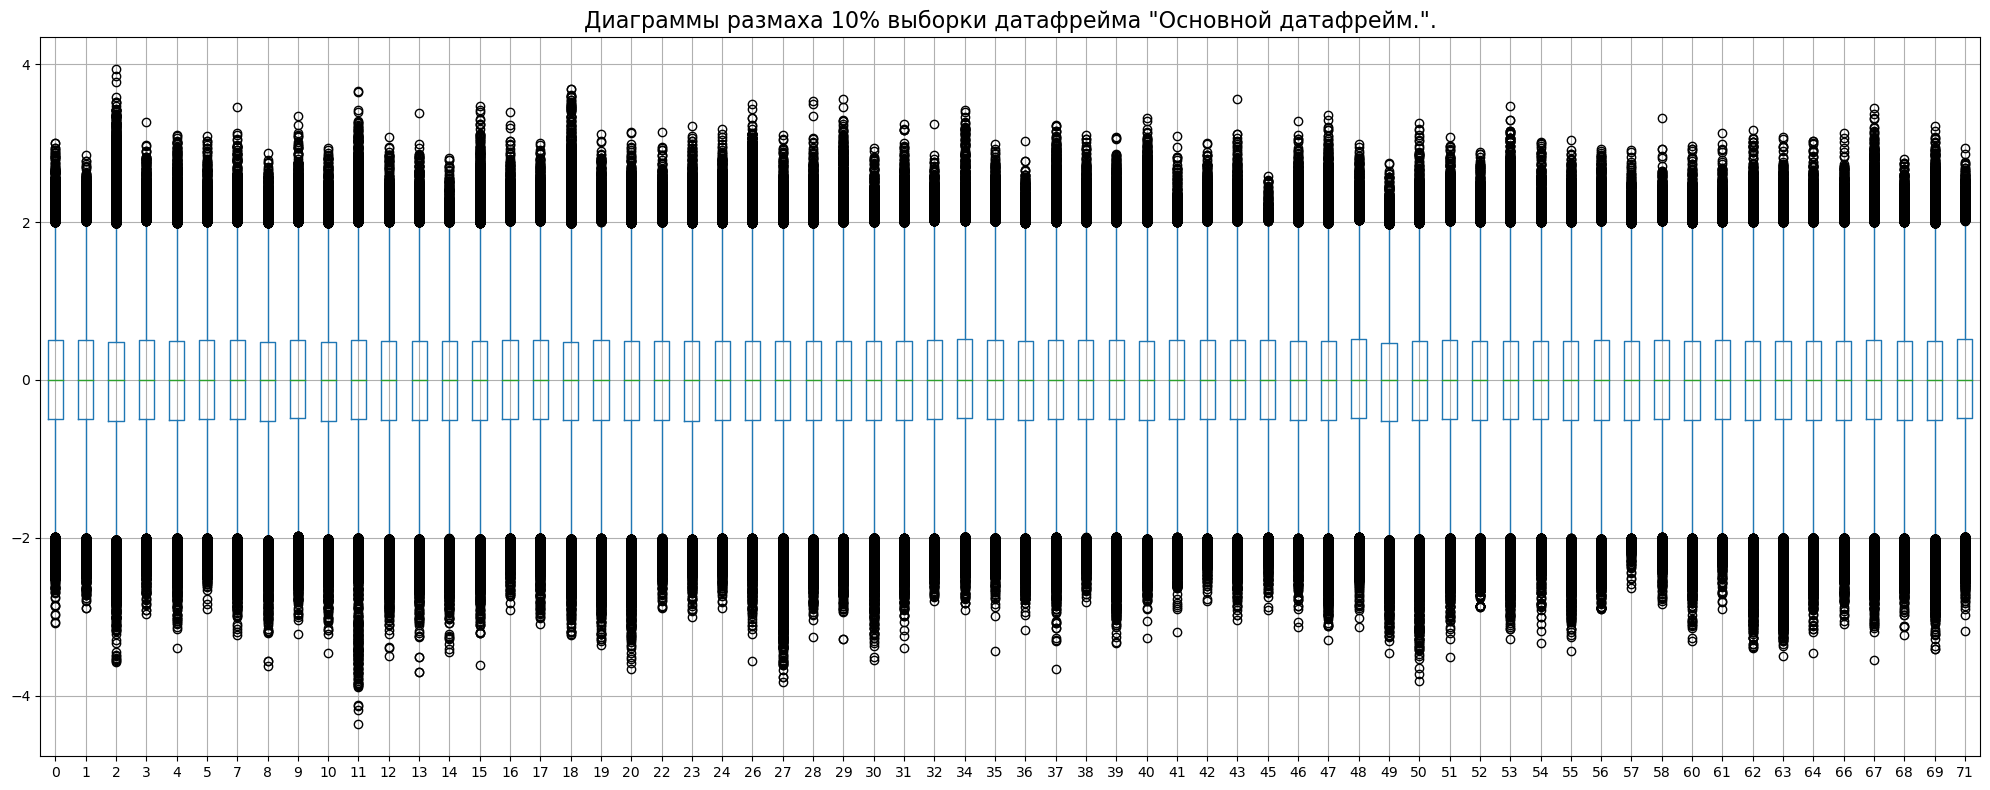

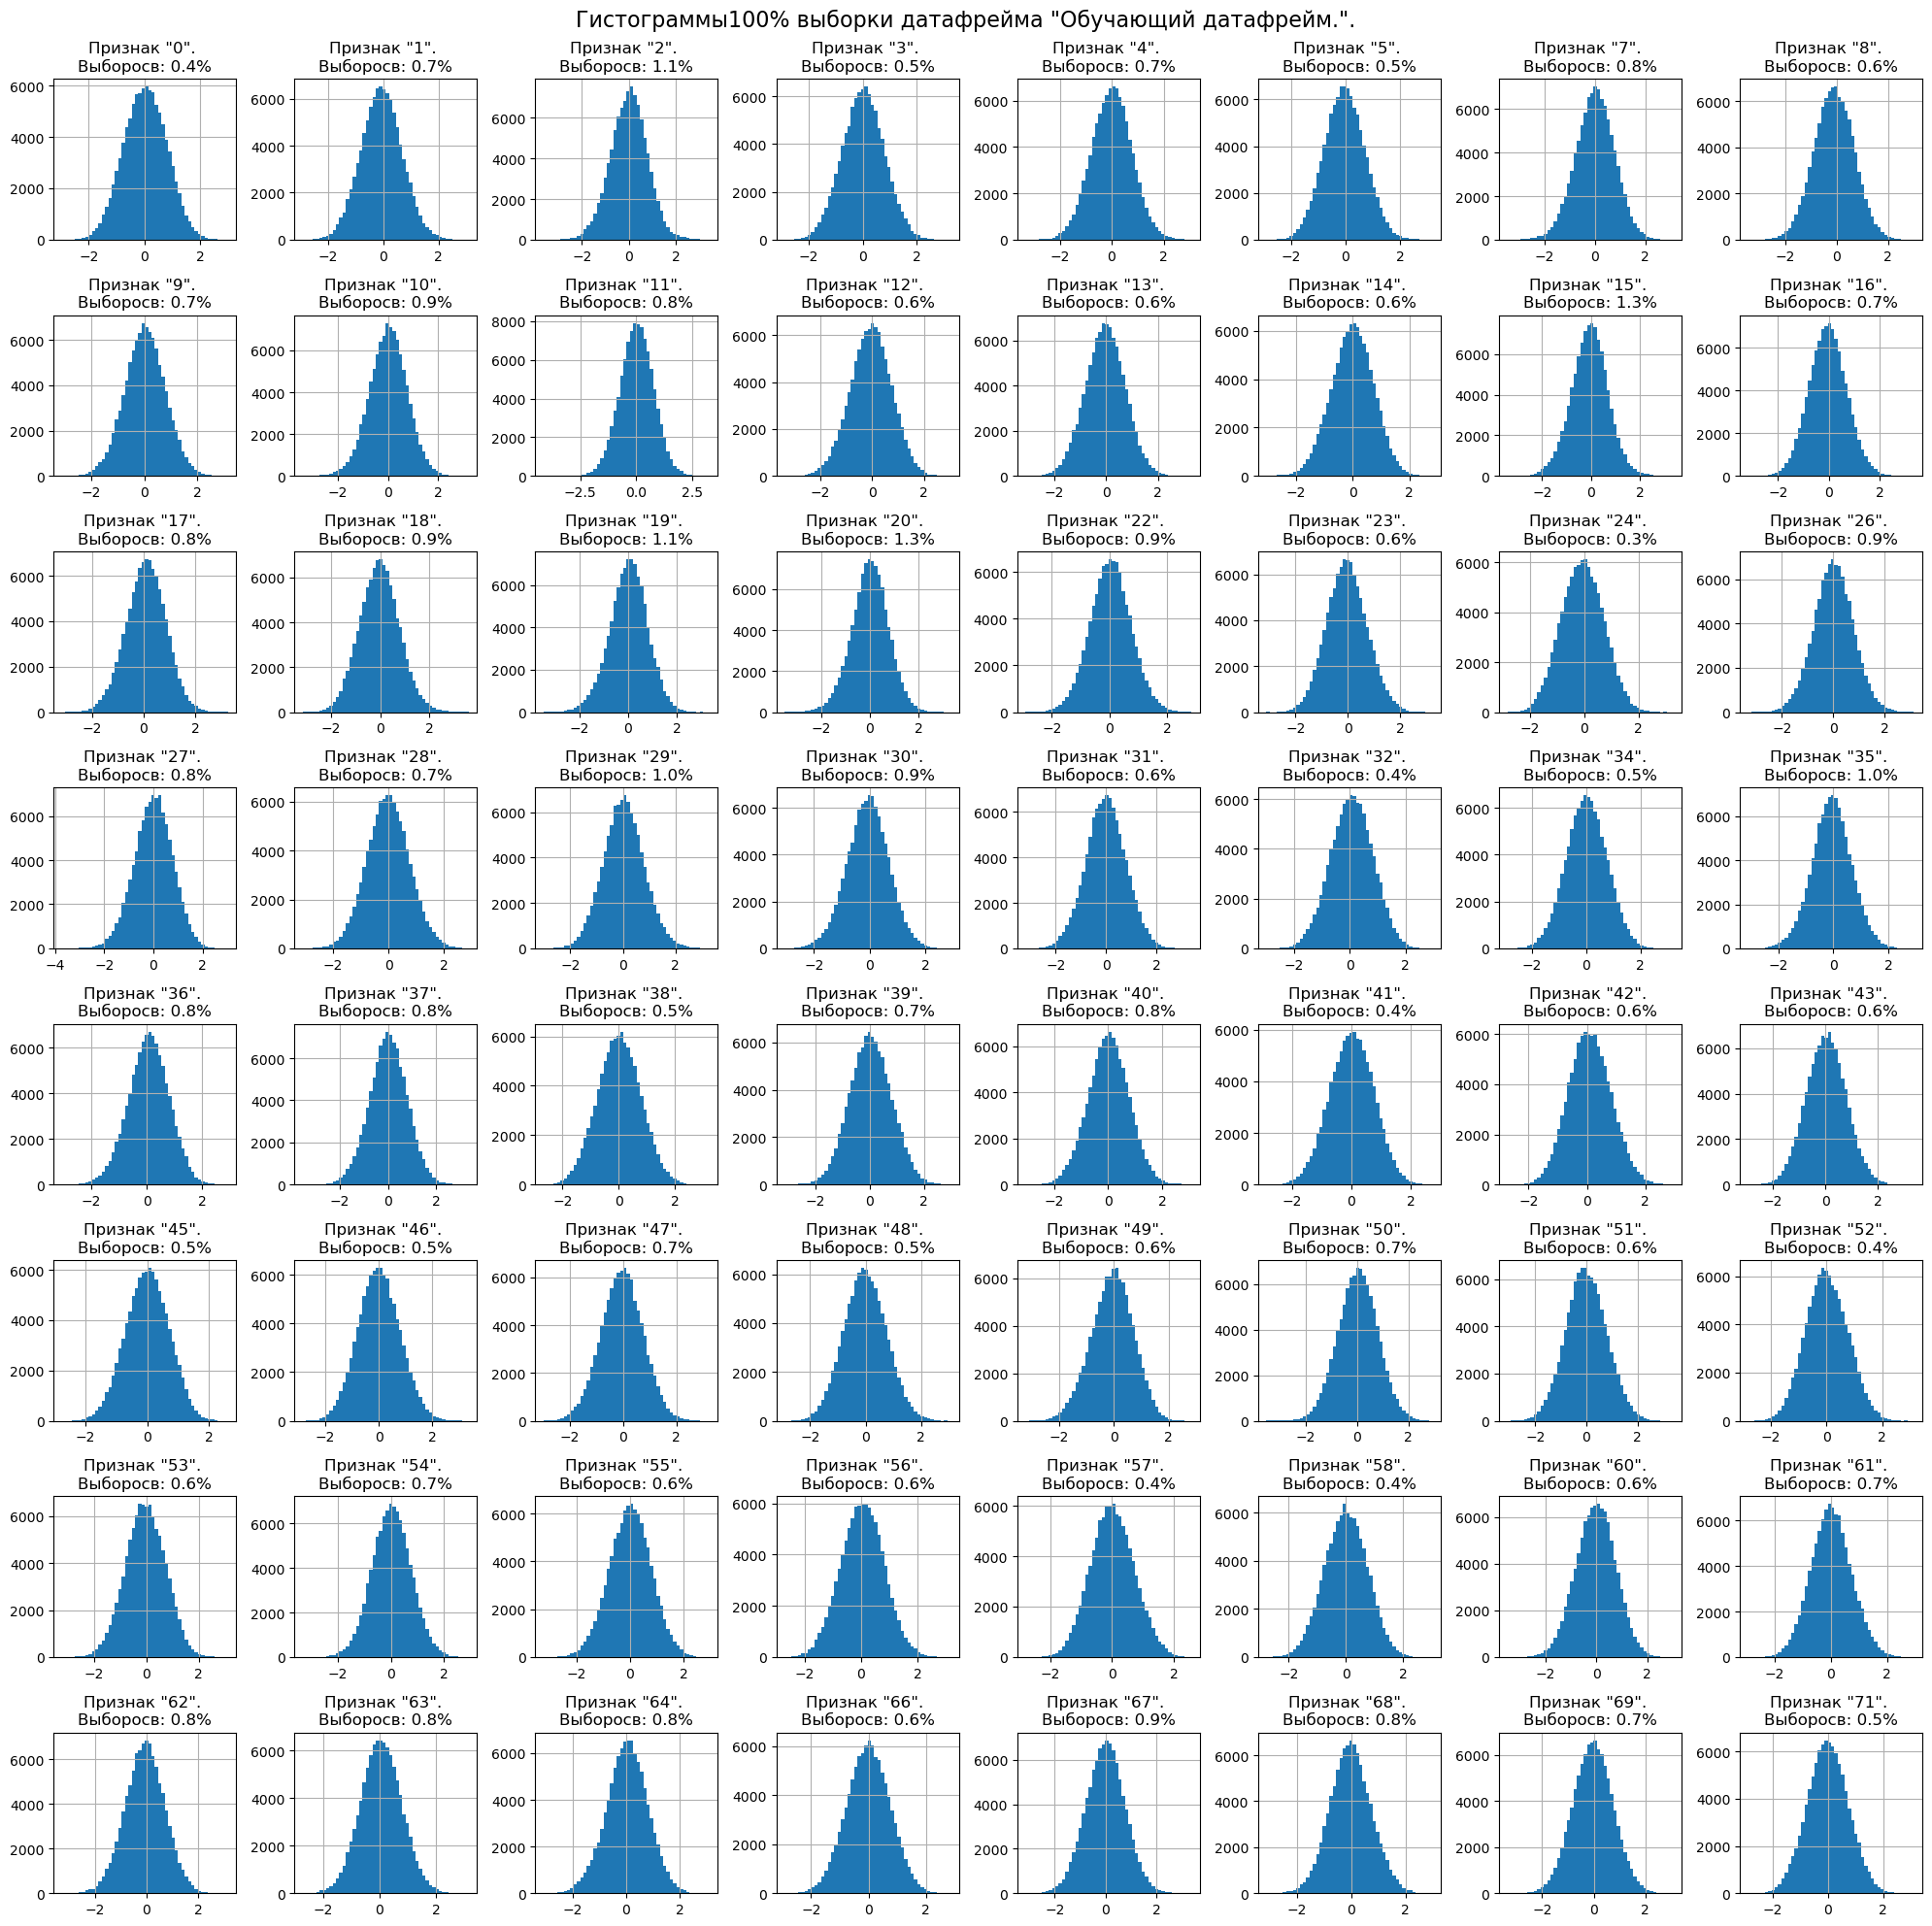

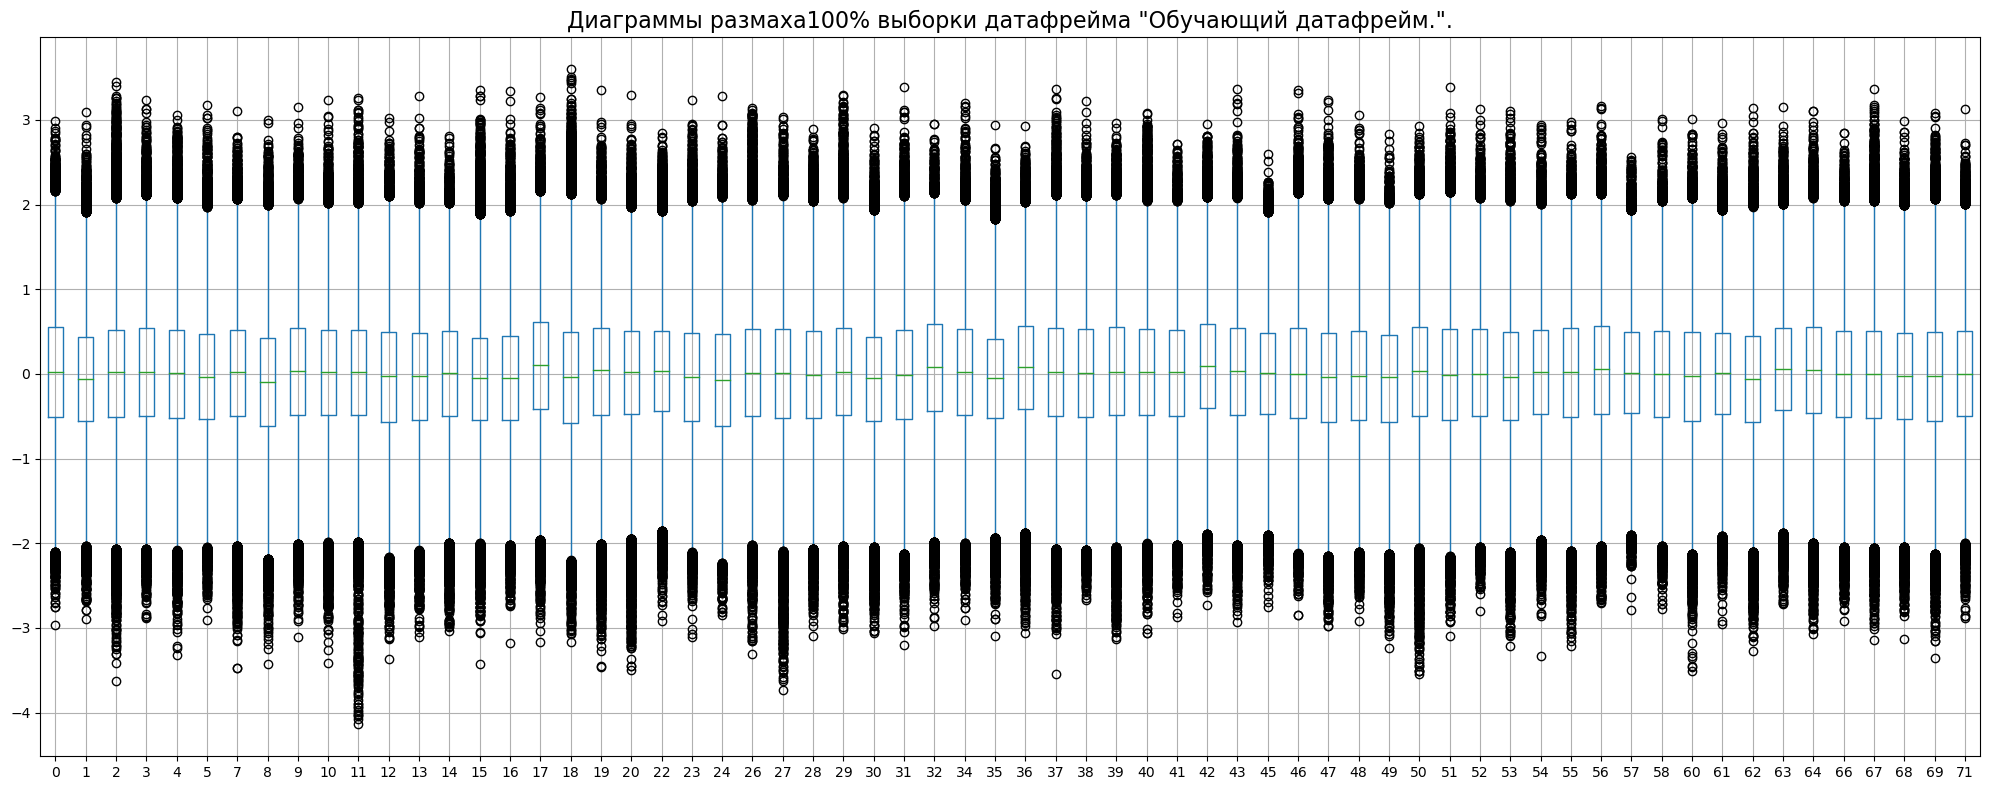

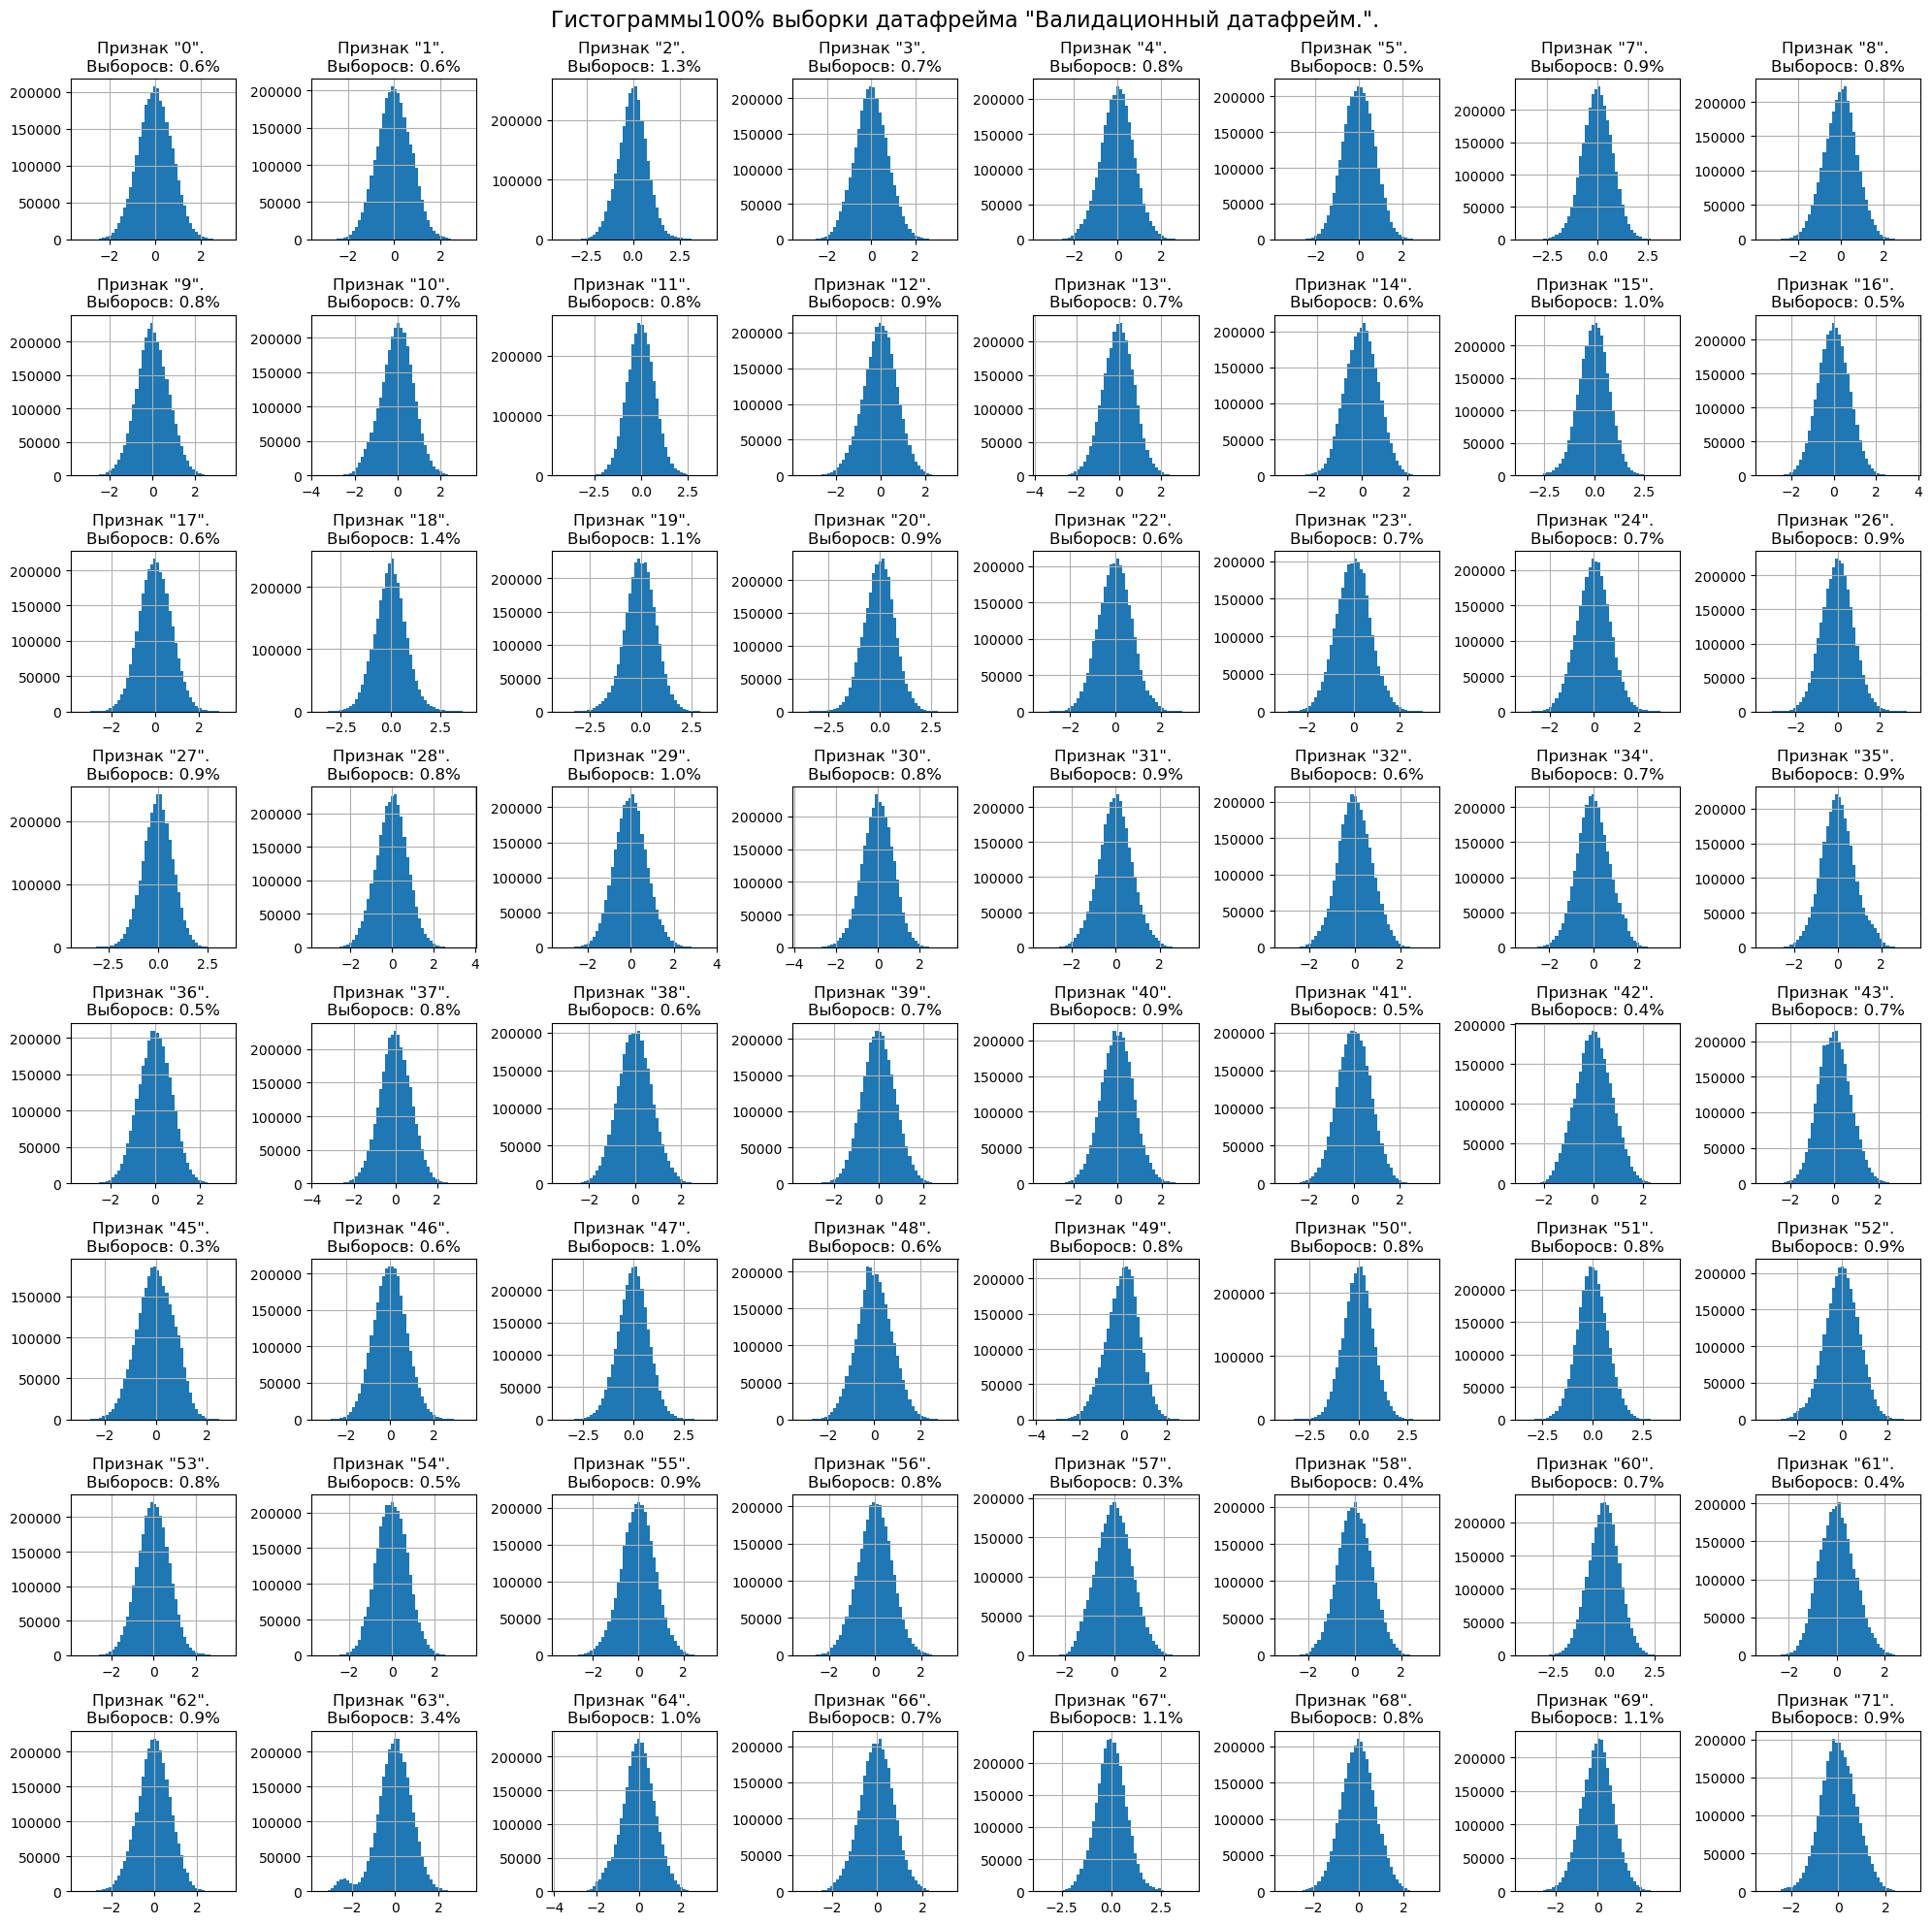

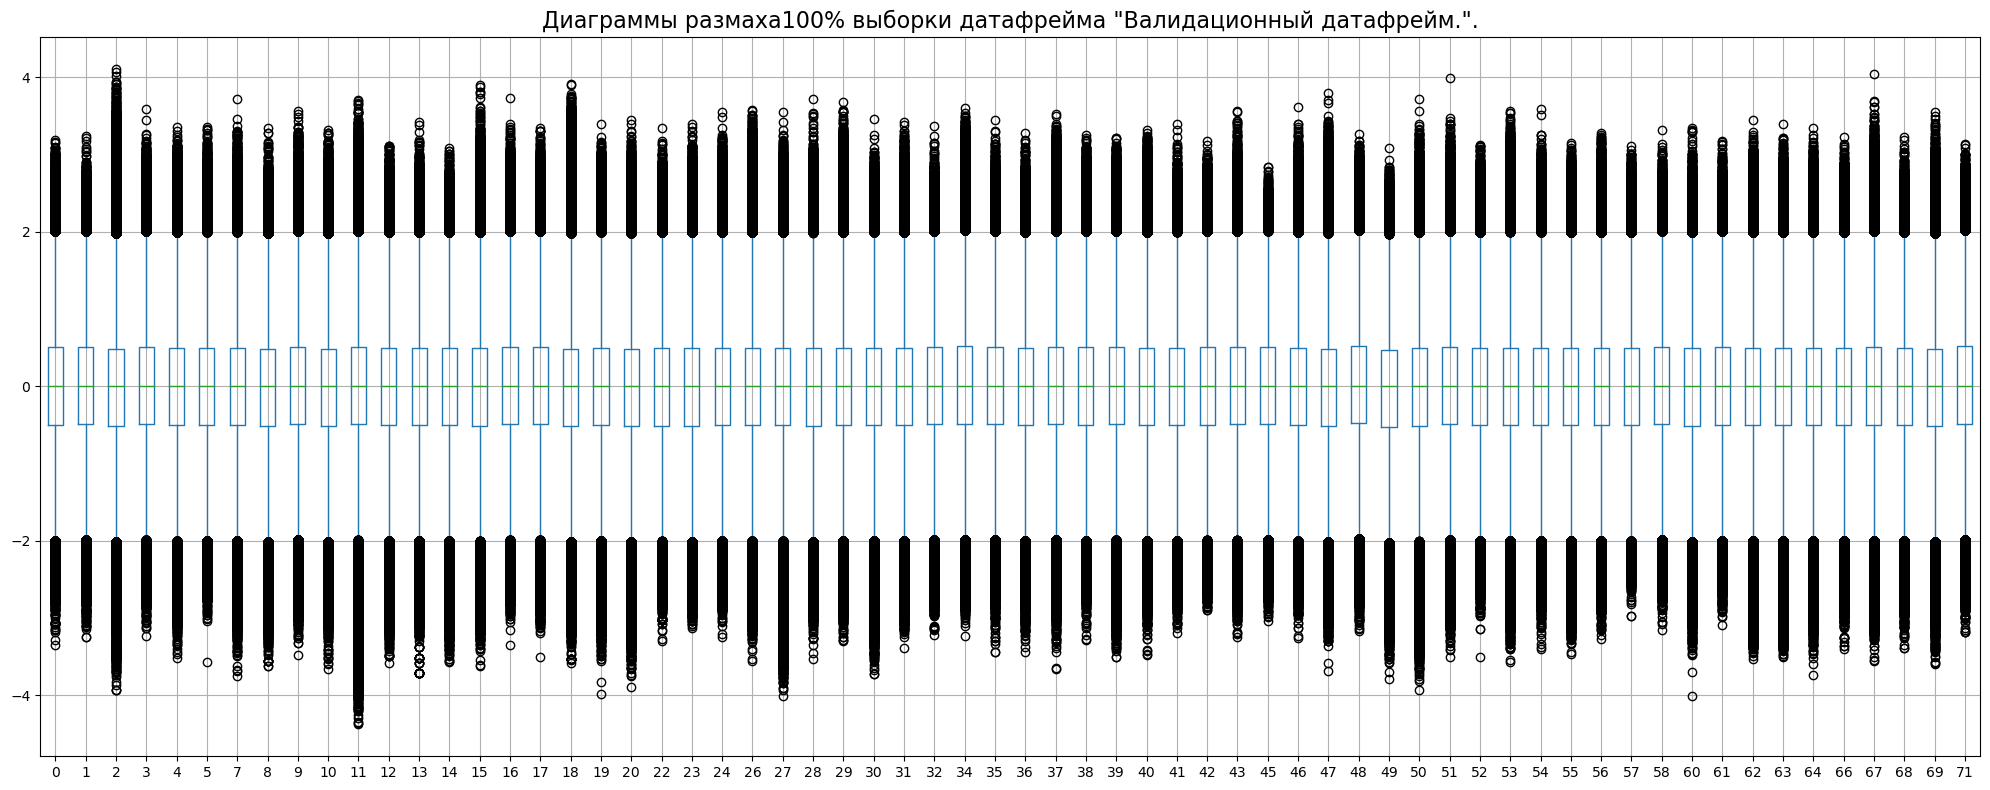

CPU times: total: 1min 16s
Wall time: 1min 16s


In [25]:
%%time
# Удалим признаки, с ненормальным распределеним.
cols = ['6', '21', '25', '33', '44', '59', '65', '70']
df_base_rs = df_base.drop(cols, axis=1)
df_train_rs = df_train.drop(cols, axis=1)
df_val_rs = df_val.drop(cols, axis=1)

# Смасштабируем оставшиеся признаки.
rs = RobustScaler()
df_base_rs = pd.DataFrame(rs.fit_transform(df_base_rs),
                          columns=df_base_rs.columns,
                          index=df_base_rs.index)
df_train_rs = pd.DataFrame(rs.transform(df_train_rs),
                           columns=df_train_rs.columns,
                           index=df_train_rs.index)
df_val_rs = pd.DataFrame(rs.transform(df_val_rs),
                         columns=df_val_rs.columns,
                         index=df_val_rs.index)

# Выведем графики для подвыборки для вcех признаков 
# основного датафреймаи и графики для остальных датафреймов.
plot_graphs(df=df_base_rs, 
              name='Основной датафрейм.', 
              sample_frac=.1)
plot_graphs(df=df_train_rs, 
              name='Обучающий датафрейм.')
plot_graphs(df=df_base_rs, 
              name='Валидационный датафрейм.')

# Удалим временные переменные.
del [df_base_t, df_train_t]

### Базовые модели. Промежуточный вывод.
- Проведено удалени признаков с ненормальным распределением `6`, `21`, `25`, `33`, `44`, `59`, `65`, `70`.
- Проведено масштабирование с использованием `RobustScaler`.

## Вычисление оптимального кол-ва кластеров.
Найдём оптимальное кол-во кластеров - `n` итерацией алгоритма `KMeans` и
- методом "локтя": вычислением сумм квадратов внутрикластерных расстояний до центроида (параметр `inertia_` в `sklearn`) для каждого `n` и нахождением точки слома на графике;
- методом вычислениея коэффициента силуэта, `silhouette_score`, - меры схожести точки с другими в кластере, по сравнению с другими кластерами, по формуле: $S(i) = \frac{b(i) - a(i)}{max\{a(i), b(i)\}}$ , где
  - $S(i)$ &nbsp;коэффициент силуэта для точки i,
  - $a(i)$ &nbsp;среднее расстояние между точкой i и другими точками её кластера,
  - $b(i)$ &nbsp;среднее расстояние между точкой i и точками ближайшего кластера.

In [26]:
# Функция построения графиков для коэффициентов метода "локтя" 
# и силуэта.
def get_k_plots(df : pd.DataFrame(),
                k_list : list, 
                sample_size : None, 
                seed = 12345):
    '''
    Calculates silhouette and sum of squared distance coefficients 
    and plots them for each k.
    Arguments:
    - df: dataframe to evaluate.
    - model: KMeans / MiniBatchKMeans.
    - k_list: list of numbers of clusters to evaluate.
    - sample_size: int. sample size for silhouette coefficient.
    '''
    # Зададим списки для сбора коэфф.
    silhouette_avg = []
    sum_squared_dist = []

    # Вычислим коэффициенты.
    for ni in tqdm(k_list):
        # Инициализация KMeans / MiniBatchKMeans.
        if sample_size:
            cluster_k = MiniBatchKMeans(n_clusters=ni, 
                                        init='k-means++', 
                                        n_init='auto', 
                                        batch_size=1536, 
                                        random_state=seed)
            cluster_k.fit(df)
            # Запишем коэффициент силуэта.
            silhouette_avg.append(silhouette_score(df, 
                                                   cluster_k.labels_, 
                                                   sample_size=sample_size, 
                                                   random_state=seed))
        else:
            cluster_k = KMeans(n_clusters=ni, 
                               init='k-means++', 
                               n_init='auto', 
                               random_state=12345)
            cluster_k.fit(df)

            # Запишем коэффициент силуэта.
            silhouette_avg.append(silhouette_score(df, 
                                                   cluster_k.labels_, 
                                                   random_state=seed))
        # Запишем сумму квадратов расстояний.
        sum_squared_dist.append(cluster_k.inertia_)

    # Выведем графики.
    plt.figure(figsize=(10, 10))
    plt.plot(k_list, silhouette_avg, 'x-')
    plt.plot(k_list, [el*1e-9 for el in sum_squared_dist], 'o-');
    # plt.axvline(x=50, ls=':')
    plt.legend(['Коэффициент силуэта.',
                'Сумма квадратов расстояний \n(1e-9).',
                'Оптимальное число кластеров.'])
    plt.xlabel('Кол-во кластеров.')
    plt.xticks(k_list)
    plt.ylabel('Коэффициенты.')
    plt.title('Поиск оптимального кол-ва кластеров.\n"Метод '+
              'локтя" и "коэфф. силуэта".')
    plt.show();

  0%|          | 0/8 [00:00<?, ?it/s]

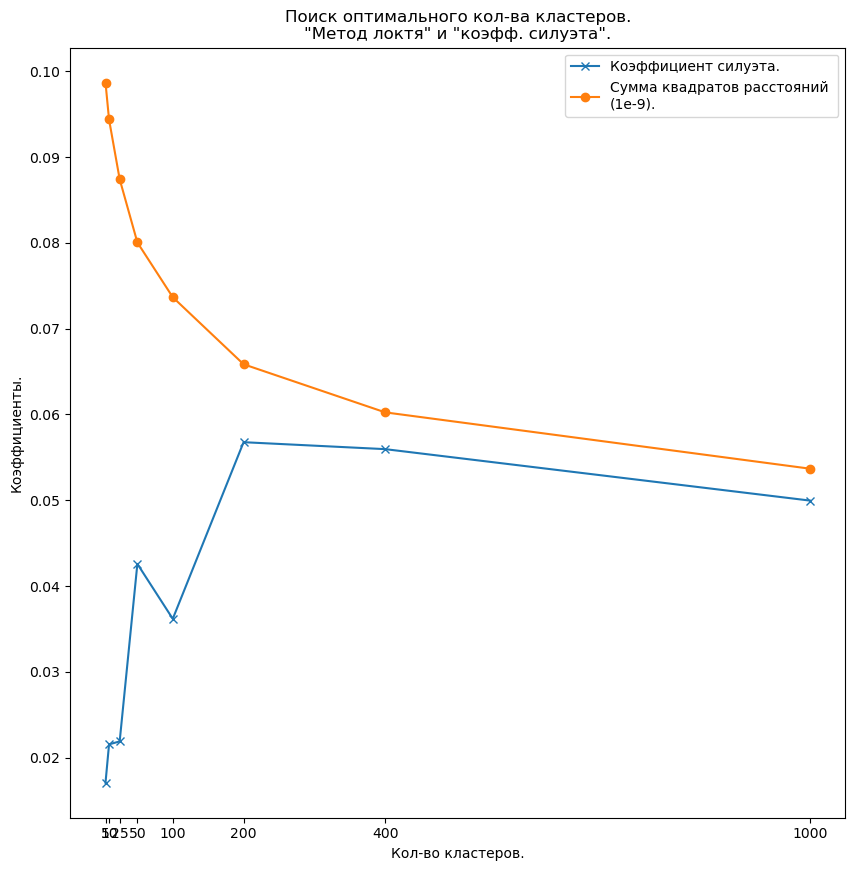

CPU times: total: 7min 36s
Wall time: 1min 57s


In [27]:
%%time
# Вызовем функцию и построим график.
get_k_plots(df_base_rs, 
            sample_size = 25000, 
            k_list=[5, 10, 25, 50, 100, 200, 400, 1000])

### Определение оптимального кол-ва кластеров через коэффициенты кластеризации.
- Создадим функцию вычисления коэффицента схожести кластеров Дэвиса-Болдина: меньше - лучше.
- Для экономии времени исполнения кода вычислим коэффициенты для `MiniBatchKMeans`, которые должны приближенно соответствовать коэффициентам для `KMeans`.

In [28]:
# Вычисление оптимального кол-ва кластеров.
def get_clustering_coeff(df: pd.DataFrame(), 
                         n_clusters: list, 
                         model = KMeans,
                         seed = 12345):
    '''
    Calculates Davis-Bouldin coefficient for provided dataframe 
    and numbers of clusters.
    '''
    if isinstance(n_clusters, int):
        n_clusters = [n_clusters]

    print('Коэффициент схожести кластеров Девиса-Боулдина: '+
          'меньше - лучше, минимум = 0.')
    
    for ni in tqdm(n_clusters):
        # Инициализация KMeans / MiniBatchKMeans.
        if model == MiniBatchKMeans:
            cluster_k = MiniBatchKMeans(n_clusters=ni, 
                                        init='k-means++', 
                                        n_init='auto', 
                                        batch_size=1536, 
                                        random_state=seed).fit(df)
        elif model == KMeans:
            cluster_k = KMeans(n_clusters=ni, 
                               init='k-means++', 
                               n_init='auto', 
                               random_state=seed).fit(df)
        
        # Разделим df на ni кластеров.
        db_score = davies_bouldin_score(df, cluster_k.labels_)
        print(f'{ni} кластеров: {round(db_score, 3)}.\n-----')

In [29]:
%%time
get_clustering_coeff(df=df_base_rs, 
                     n_clusters=[10, 20, 50, 100, 200, 
                                 300, 400, 500],
                     model=MiniBatchKMeans)

Коэффициент схожести кластеров Девиса-Боулдина: меньше - лучше, минимум = 0.


  0%|          | 0/8 [00:00<?, ?it/s]

10 кластеров: 4.996.
-----
20 кластеров: 4.18.
-----
50 кластеров: 3.288.
-----
100 кластеров: 2.995.
-----
200 кластеров: 2.812.
-----
300 кластеров: 2.935.
-----
400 кластеров: 2.88.
-----
500 кластеров: 2.854.
-----
CPU times: total: 5min 54s
Wall time: 1min 36s


## Тесты параметров  `ANNOY`.

### `ANNOY`. Тест параметров.

In [32]:
%%time
# Зададим список для сбора данных.
trees_results_1_list = []

# Соберём данные.
for annoy_n_trees, annoy_search_n_nodes in product(
    [50, 100, 150],
    [100, 200]
):
    # Получим значения целевой метрики acuracy@5.
    acc_annoy, time_annoy = get_accuracy(
        df = df_base_rs, 
        df_eval = df_train_rs, 
        target = target_train,
        model_type= 'annoy',
        annoy_n_trees = annoy_n_trees,
        annoy_search_n_nodes = annoy_search_n_nodes
    )
    trees_results_1_list.append([annoy_n_trees,
                                 annoy_search_n_nodes,
                                 acc_annoy, 
                                 time_annoy])
    
# Создадим и выведем таблицу с результатами.
columns = ['Кол-во деревьев:', 'Кол-во узлов для поиска',
           'accuracy@5:', 'Время поиска (сек.):']
trees_results_1 = pd.DataFrame(trees_results_1_list, 
                               columns=columns)

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: total: 1h 44min 43s
Wall time: 19min 43s


In [33]:
display(trees_results_1
        .sort_values(by='accuracy@5:', ascending=False)
        .style
        .format(precision=3)
        .set_caption('Тестирование ANNOY.'))

,Кол-во деревьев:,Кол-во узлов для поиска,accuracy@5:,Время поиска (сек.):
5,150,200,66.885,19.610
3,100,200,66.567,17.360
1,50,200,65.835,12.680
4,150,100,64.896,15.660
2,100,100,64.454,13.170
0,50,100,63.589,9.480


## Финальная модель. Тестирование.

In [ ]:
 acc_annoy, time_annoy = get_accuracy(
        df = df_base_rs, 
        df_eval = df_train_rs, 
        target = target_train,
        model_type= 'annoy',
        annoy_n_trees = 200,
        annoy_search_n_nodes = 150
    )
    

results = pd.DataFrame([[150, 200,
                        acc_annoy, time_annoy]], 
                       columns=['Кол-во деревьев:', 'Кол-во узлов для поиска',
                                'accuracy@5:', 'Время поиска (сек.):'])

display(results
        .style
        .format(precision=3)
        .set_caption('Финальная модель.\nВалидационная выборка.'))

# Общий вывод.
## Результат работы.
  - Значение целевой метрики `accuracy@5` 66.351 было достигнуто с использованием модели `ANNOY` с параметрами
    - кол-во деревьев 150;
    - кол-во узлов для поиска 200;
  - на смасштабированных с помощью `RobustScaler` данных;
  - с удалением признаков, распределённых ненормально.
  
## Задача.
  - Был разработан алгоритм, который для всех товаров из `validation.csv` находит 5 похожих из `base.csv`.
  
## Использовавшиеся в тестировании модели. 
`ANNOY`.

## План работы.
- [Загрузка библиотек.](#Загрузка-библиотек.)
- [Установка параметров проекта.](#Установка-параметров-проекта.)
- [Ознакомление с данными, ИАД.](#Ознакомление-с-данными,-ИАД.)
- [Предобработка данных.](#Предобработка-данных.)
- [Базовые модели.](#Базовые-модели.)
- [Вычисление оптимального кол-ва кластеров.](#Вычисление-оптимального-кол-ва-кластеров.)
- [Тесты параметров `ANNOY`.](#Тесты-параметров-FAISS-/-ANNOY.)

## Данные.
- Размер датасетов:
  - `df_base`: 2918139 X 72 с идентификаторами объектов в индексе;
  - `df_train`: 100000 X 73, в т.ч. признак ответов, и с идентификаторами объектов в индексе;
  - `df_val`: 100000 X 72 с идентификаторами объектов в индексе;
  - `df_val_answers`: 100000 X 1 - признак ответов с идентификаторами объектов в индексе.
- Распределение признаков.
  - Признаки 6, 21, 25, 33, 44, 59, 65, 70 имеют ненормальное распределение. Остальные признаки имеют распределения приближенные к нормальному. <br>
  Из-за невозможности идентификации признаков и неэффективности преобразований распределений признаков с точки зрения целевой метрики, признаки с ненормальным распределением были удалены.
- Выбросы / аномалии.
  - Почти во всех признаках среднее близко к медиане и присутствует минимальный процент выбросов. Удаление / замена выбросов средним не оказались эффективнымы.